In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
import pandas as pd
import os
import sys
sys.path.append('/home/alvin/miniconda3/lib/python3.6/site-packages')
import zipfile
import requests
import numpy as np
from sklearn import dummy, metrics, cross_validation, ensemble

import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras

In [2]:
# Download the dataset. It's small, only about 6 MB.
if not os.path.exists('./ml-1m'):
    url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    response = requests.get(url, stream=True)
    total_length = response.headers.get('content-length')
    bar = tqdm.tqdm_notebook(total=int(total_length))
    with open('./ml-1m.zip', 'wb') as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            bar.update(4096)
    zip_ref = zipfile.ZipFile('./ml-1m.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()

NameError: name 'tqdm' is not defined

In [21]:
users = pd.read_csv('./data/user2.csv', sep='::', 
                        engine='python', 
                        names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']).set_index('UserID')
ratings = pd.read_csv('./data/train2.csv', engine='python', 
                          sep=',', names=['TrainDataID', 'UserID', 'MovieID', 'Rating']).set_index('TrainDataID')
movies = pd.read_csv('./data/movies2.csv', engine='python',
                         sep='::', names=['MovieID', 'Title', 'Genres']).set_index('MovieID')
testData = pd.read_csv('./data/test2.csv', engine='python',
                         sep=',', names=['TestDataID', 'UserID', 'MovieID'])
movies['Genres'] = movies.Genres.str.split('|')

users.Age = users.Age.astype('category')
users.Gender = users.Gender.astype('category')
users.Occupation = users.Occupation.astype('category')
ratings.MovieID = ratings.MovieID.astype('category')
ratings.UserID = ratings.UserID.astype('category')
testData.MovieID = testData.MovieID.astype('category')
testData.UserID = testData.UserID.astype('category')

In [49]:
frames = [ratings.MovieID, testData.MovieID]
ref = pd.concat(frames)

res = pd.DataFrame(ref, columns = ['MovieID'] )
res.MovieID = res.MovieID.astype('category')
print(res)

       MovieID
1         1193
2          661
3          914
4         3408
5         2355
6         1197
7         1287
8         2804
9          919
10         595
11         938
12        2398
13        2918
14        1035
15        2791
16        2687
17        2018
18        3105
19        2797
20        2321
21         720
22         527
23        2340
24          48
25        1097
26        1721
27        1545
28         745
29        2294
30        3186
...        ...
100306    2872
100307    2134
100308     300
100309    3521
100310    1921
100311    2599
100312    3543
100313    1960
100314    1975
100315    1200
100316    1240
100317    1251
100318     720
100319    1263
100320    1265
100321     750
100322    2612
100323    1674
100324    2641
100325    2645
100326    1307
100327     495
100328    2303
100329    1392
100330    2366
100331     111
100332    3334
100333    2717
100334    1784
100335    1096

[1000209 rows x 1 columns]


In [28]:
print(ratings.MovieID.shape)
print(testData.MovieID.shape)

(899873,)
(100336,)


In [56]:
uframes = [ratings.UserID, testData.UserID]
uref = pd.concat(uframes)

ures = pd.DataFrame(uref, columns = ['UserID'] )
ures.UserID = ures.UserID.astype('category')

userid = ures.UserID.cat.codes.values
trainUserID = userid[0:ratings.UserID.shape[0]]
testUserID = userid[ratings.UserID.shape[0]:]
print(trainUserID.shape)
print(testUserID.shape)



(899873,)
(100336,)


In [53]:
# Count the movies and users
n_movies = movies.shape[0]
n_users = users.shape[0]

# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movieid = res.MovieID.cat.codes.values
trainMovieID = movieid[0:ratings.MovieID.shape[0]]
testMovieID = movieid[ratings.MovieID.shape[0]:]
print(trainMovieID.shape)
print(testMovieID.shape)


userid = ratings.UserID.cat.codes.values

print(mid[0:20])
print(movieid[0:20])
print(userid[0:20])

(899873,)
(100336,)
[1098  636  847 3163 2152 1101 1189 2588  852  579  871 2195 2699  964 2575
 2472 1829 2878 2581 2118]
[1104  639  853 3177 2162 1107 1195 2599  858  581  877 2205 2710  970 2586
 2483 1838 2889 2592 2128]
[795 795 795 795 795 795 795 795 795 795 795 795 795 795 795 795 795 795
 795 795]


In [10]:
np.array(ratings.Rating)

array([5, 3, 3, ..., 5, 5, 4])

In [50]:
# And finally, set up a y variable with the rating,
# as a one-hot encoded matrix.
#
# note the '- 1' for the rating. That's because ratings
# go from 1 to 5, while the matrix columns go from 0 to 4

y = np.zeros((ratings.shape[0], 5))
y[np.arange(ratings.shape[0]), ratings.Rating - 1] = 1

In [52]:
# Dummy classifier! Just see how well stupid can do.
pred = dummy.DummyClassifier(strategy='prior')
pred.fit(ratings[['UserID', 'MovieID']], ratings.Rating)

print(metrics.mean_absolute_error(ratings.Rating, pred.predict(ratings[['UserID', 'MovieID']])))

0.870707310921


In [53]:
# Now, the deep learning classifier

# First, we take the movie and vectorize it.
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
movie_input = keras.layers.Input(shape=[1])
movie_vec = keras.layers.Flatten()(keras.layers.Embedding(n_movies + 1, 32)(movie_input))
movie_vec = keras.layers.Dropout(0.5)(movie_vec)

# Same thing for the users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(keras.layers.Embedding(n_users + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = keras.layers.merge([movie_vec, user_vec], mode='concat')
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(input_vecs))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(nn))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = kmodels.Model([movie_input, user_input], result)
model.compile('adam', 'categorical_crossentropy')

# If we wanted to inspect part of the model, for example, to look
# at the movie vectors, here's how to do it. You don't need to 
# compile these models unless you're going to train them.
final_layer = kmodels.Model([movie_input, user_input], nn)
movie_vec = kmodels.Model(movie_input, movie_vec)

/home/alvin/miniconda3/envs/hw6/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/alvin/miniconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [54]:
# Split the data into train and test sets...
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(movieid, userid, y)

In [ ]:
# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
metrics.mean_absolute_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

Train on 750156 samples, validate on 250053 samples
Epoch 1/20
750156/750156 [==============================] - 302s - loss: 1.3333 - val_loss: 1.2478
Epoch 2/20
750156/750156 [==============================] - 323s - loss: 1.2639 - val_loss: 1.2287
Epoch 3/20
750156/750156 [==============================] - 327s - loss: 1.2508 - val_loss: 1.2257
Epoch 4/20
750156/750156 [==============================] - 293s - loss: 1.2434 - val_loss: 1.2222
Epoch 5/20
750156/750156 [==============================] - 316s - loss: 1.2402 - val_loss: 1.2173
Epoch 6/20
750156/750156 [==============================] - 301s - loss: 1.2366 - val_loss: 1.2159
Epoch 7/20
750156/750156 [==============================] - 314s - loss: 1.2334 - val_loss: 1.2150
Epoch 8/20
750156/750156 [==============================] - 322s - loss: 1.2324 - val_loss: 1.2153
Epoch 9/20
750156/750156 [==============================] - 313s - loss: 1.2303 - val_loss: 1.2139
Epoch 10/20
750156/750156 [==============================

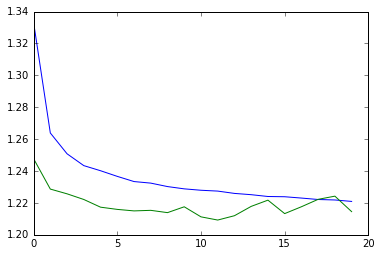

In [22]:
try:
    history = model.fit([a_movieid, a_userid], a_y, 
                         nb_epoch=20, 
                         validation_data=([b_movieid, b_userid], b_y))
    plot(history.history['loss'])
    plot(history.history['val_loss'])
except KeyboardInterrupt:
    pass

In [23]:
# This is the number that matters. It's the held out 
# test set score. Note the + 1, because np.argmax will
# go from 0 to 4, while our ratings go 1 to 5.
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

0.67782430124813542

In [24]:
# For comparison's sake, here's the score on the training set.
metrics.mean_absolute_error(
    np.argmax(a_y, 1)+1, 
    np.argmax(model.predict([a_movieid, a_userid]), 1)+1)

0.65481579831395065